# Covariance estimators using Factor models

In [1]:
import pandas as pd
import edhec_risk_kit as erk
import fama_french_import as ff
import yahoo_import as yahoo

### Data Import

Import Portfolio returns and market cap

In [2]:
portfolio = yahoo.read_portfolio("tech_portfolio")
portfolio_returns = yahoo.read_portfolio_data(portfolio)
portfolio_returns.head()

,AMZN,GOOGL,MSFT,FB,AAPL,TSM,INTC,QCOM,AVGO,AMD
Date,,,,,,,,,,
2012-05-18,-0.020654,-0.036353,-0.015141,NaN,0.000490,-0.028572,-0.004582,-0.020644,-0.001663,-0.019576
2012-05-21,0.019920,0.022835,0.016399,-0.109861,0.058261,0.009804,0.003069,0.022151,0.029647,0.048253
2012-05-22,-0.012746,-0.021674,0.000336,-0.089039,-0.007679,-0.001387,-0.004589,0.012408,0.011647,-0.022222
2012-05-23,0.009056,0.014414,-0.021841,0.032258,0.024400,-0.022222,-0.022666,0.003625,0.071954,-0.012987
2012-05-24,-0.009389,-0.009517,-0.001375,0.032187,-0.009184,-0.008523,0.008255,-0.017028,-0.030131,-0.009868


<AxesSubplot:xlabel='Date'>

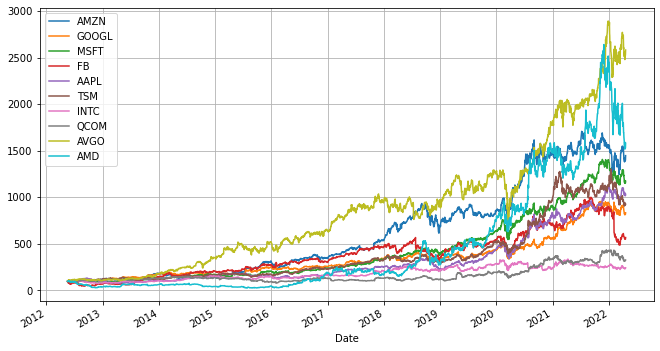

In [3]:
wealth = erk.compound_returns(portfolio_returns, 100)
wealth.plot(grid=True, figsize=(11,6))

### Backtest weight allocation

Plot the returns of an equally weighted portfolio and a constant capitalization weighted portfolio

In [4]:
portfolio_returns = erk.resample_returns(portfolio_returns, period="M").fillna(0)

<AxesSubplot:xlabel='Date'>

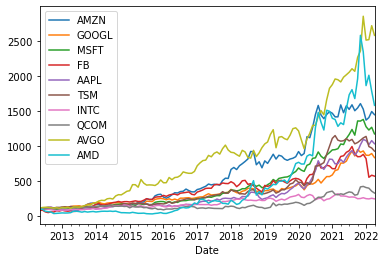

In [5]:
erk.compound_returns(portfolio_returns, 100).plot()

In [6]:
ewr = erk.backtest_weight_scheme(portfolio_returns, window=12, weight_scheme=erk.weight_ew)
cwr = erk.backtest_weight_scheme(portfolio_returns, window=12, weight_scheme=erk.weight_constant_cap, cap_ws=portfolio["marketCap"])

btr = pd.DataFrame({"EW": ewr, "CWR": cwr})

<AxesSubplot:xlabel='Date'>

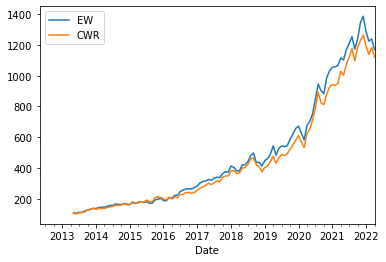

In [7]:
erk.compound_returns(btr, 100).plot()

In [8]:
erk.summary_stats(btr)

,Ann. return,Ann. vol,Sharpe ratio,Skewness,Kurtosis,Historic CVar,C-F Var,Max Drawdown
EW,0.278796,0.185578,1.324761,-0.100122,3.064021,NaN,0.064718,-0.169201
CWR,0.273541,0.185156,1.300067,-0.066818,2.698938,NaN,0.064808,-0.192515


### Building the global minimum variance portfolio

In [9]:
# minimum variance index portfolio using standard covariance matrix
mvr = erk.backtest_weight_scheme(portfolio_returns, window=12, weight_scheme=erk.weight_minvar, cov_estimator=erk.sample_cov, periods_per_year=12)

# minimum variance index portfolio using constant (constant correlation) covariance matrix
mvcc = erk.backtest_weight_scheme(portfolio_returns, window=12, weight_scheme=erk.weight_minvar, cov_estimator=erk.cc_cov, periods_per_year=12)

# Max Sharpe ratio 
msr = erk.backtest_weight_scheme(portfolio_returns, window=12, weight_scheme=erk.weight_maxsharpe, cov_estimator=erk.sample_cov, periods_per_year=12)

# Max Sharpe ratio CC
msrcc = erk.backtest_weight_scheme(portfolio_returns, window=12, weight_scheme=erk.weight_maxsharpe, cov_estimator=erk.cc_cov, periods_per_year=12)


<AxesSubplot:title={'center':'Weighting schemes returns'}, xlabel='Date'>

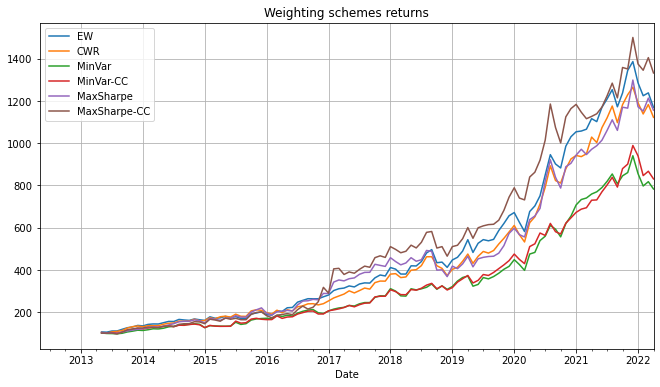

In [10]:
btr["MinVar"] = mvr
btr["MinVar-CC"] = mvcc
btr["MaxSharpe"] = msr
btr["MaxSharpe-CC"] = msrcc
bt_wealth = erk.compound_returns(btr, 100)
bt_wealth.plot(grid=True, figsize=(11,6), title="Weighting schemes returns")

In [11]:
erk.summary_stats(btr)

,Ann. return,Ann. vol,Sharpe ratio,Skewness,Kurtosis,Historic CVar,C-F Var,Max Drawdown
EW,0.278796,0.185578,1.324761,-0.100122,3.064021,NaN,0.064718,-0.169201
CWR,0.273541,0.185156,1.300067,-0.066818,2.698938,NaN,0.064808,-0.192515
MinVar,0.228572,0.186898,1.052979,0.021853,3.755836,NaN,0.066518,-0.167248
MinVar-CC,0.235861,0.185235,1.100869,0.257361,3.623944,NaN,0.061735,-0.159872
MaxSharpe,0.277320,0.218820,1.116844,0.003506,3.729212,NaN,0.077569,-0.251563
MaxSharpe-CC,0.295564,0.260280,1.007331,1.329306,7.696559,NaN,0.058328,-0.200783


Visualize weights

<AxesSubplot:>

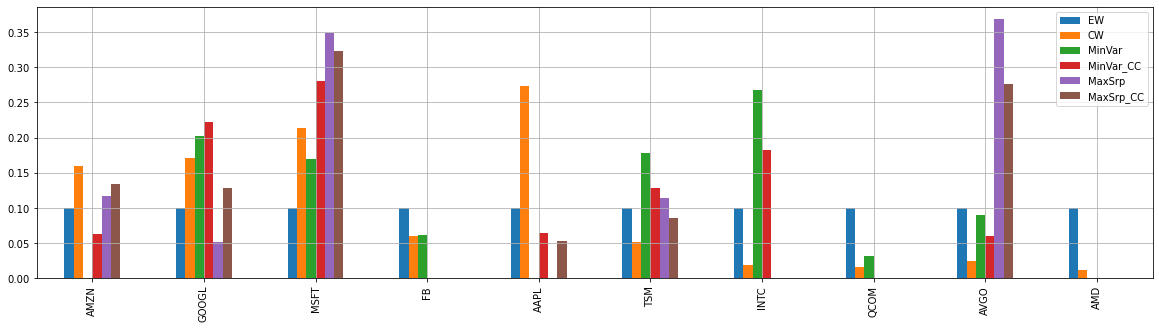

In [12]:
ww = pd.DataFrame({    
    "EW": erk.weight_ew(portfolio_returns),
    "CW": erk.weight_constant_cap(portfolio_returns, cap_ws=portfolio["marketCap"]),
    "MinVar": erk.weight_minvar(portfolio_returns, cov_estimator=erk.sample_cov),
    "MinVar_CC": erk.weight_minvar(portfolio_returns, cov_estimator=erk.cc_cov),
    "MaxSrp": erk.weight_maxsharpe(portfolio_returns, cov_estimator=erk.sample_cov),
    "MaxSrp_CC": erk.weight_maxsharpe(portfolio_returns, cov_estimator=erk.cc_cov)
})

ww.plot.bar(grid=True, figsize=(20,5))

<AxesSubplot:>

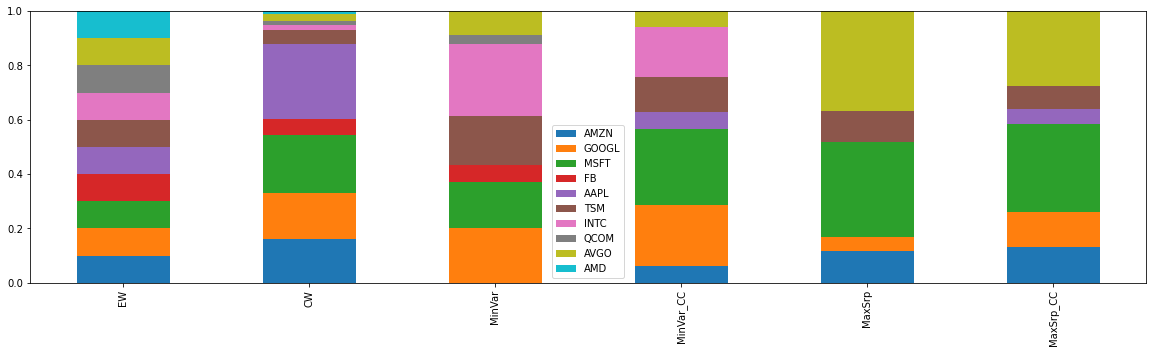

In [13]:
ww.T.plot.bar(stacked=True, figsize=(20,5))

### Introducing factor model

In [1]:
import pandas as pd
import edhec_risk_kit as erk
import fama_french_import as ff
import yahoo_import as yahoo

Import fama fench factor data, portfolio data and prepare it for analysis

Save risk free rate and select the factors necessary for analysis
You also need to add risk free rate to mkt_RF

Get the max slice of both Dataframes with the same dates

In [2]:
factors = ff.get_ff_factors("North_America_5_Factors", daily=True)
# Add total market returns column and select model factors
factors["MKT"] = factors["Mkt-RF"] + factors["RF"]
factors = factors.drop(columns=["RF", "RMW", "CMA", "Mkt-RF"])

portfolio = yahoo.read_portfolio("tech_portfolio")
portfolio_returns = yahoo.read_portfolio_data(portfolio)

# Resample monthly
factors = erk.resample_returns(factors, period = "M")
portfolio_returns = erk.resample_returns(portfolio_returns, period = "M")

# Get a compatible time slice of both df
max_date_range = erk.get_max_compatible_date_range(portfolio_returns, factors)
portfolio_returns = portfolio_returns[max_date_range[0]:max_date_range[1]]
factors = factors[max_date_range[0]:max_date_range[1]]

In [3]:
print (factors.index.min())
print (factors.index.max())

2012-05
2022-02


In [4]:
print (portfolio_returns.index.min())
print (portfolio_returns.index.max())

2012-05
2022-02


In [3]:
msrfm, weights = erk.backtest_weight_scheme(portfolio_returns, window=12, weight_scheme=erk.weight_maxsharpe, cov_estimator=erk.factor_model_cov, periods_per_year=12, factors=factors)

<AxesSubplot:xlabel='Date'>

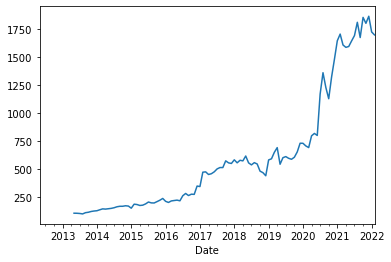

In [4]:
 erk.compound_returns(msrfm, 100).plot()

<AxesSubplot:xlabel='Date'>

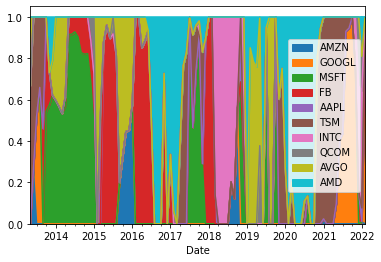

In [5]:
weights.plot.area()

Get benchmarks

<AxesSubplot:title={'center':'Weighting schemes returns'}, xlabel='Date'>

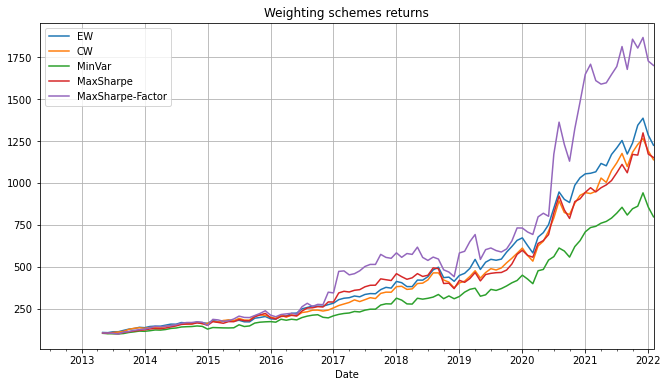

In [7]:
# Equally weighted
ewr, ewr_w = erk.backtest_weight_scheme(portfolio_returns, window=12, weight_scheme=erk.weight_ew)
# Cap weighted
cwr, cwr_w = erk.backtest_weight_scheme(portfolio_returns, window=12, weight_scheme=erk.weight_constant_cap, cap_ws=portfolio["marketCap"])
# Max Sharpe Ratio with sample covar
mvr, mvr_w = erk.backtest_weight_scheme(portfolio_returns, window=12, weight_scheme=erk.weight_minvar, cov_estimator=erk.sample_cov, periods_per_year=12)
# Max Sharpe Ratio with factor model covar
msr, msr_w = erk.backtest_weight_scheme(portfolio_returns, window=12, weight_scheme=erk.weight_maxsharpe, cov_estimator=erk.sample_cov, periods_per_year=12)

btr = pd.DataFrame()
btr["EW"] = ewr
btr["CW"] = cwr
btr["MinVar"] = mvr
btr["MaxSharpe"] = msr
btr["MaxSharpe-Factor"] = msrfm
bt_wealth = erk.compound_returns(btr, 100)
bt_wealth.head()
bt_wealth.plot(grid=True, figsize=(11,6), title="Weighting schemes returns")